In [1]:
import pandas as pd
import numpy as np
import requests
import pprint
import sidrapy
import warnings 
warnings.simplefilter("ignore")

# Estabelecer a conexão com a API do SIDRA IBGE

In [4]:
API = "https://apisidra.ibge.gov.br/values/t/1612/n3/43/v/allxp/p/last%2024/c81/2713"

Transformar o arquivo json em um Dataframe

In [5]:
req = requests.get(API)
info = req.json()

In [6]:
df = pd.DataFrame(info)
df.columns = df.iloc[0]
df = df[1:]
df.reset_index(drop=True, inplace=True)

Exluir colunas desnecessárias

In [7]:
df.drop(['Nível Territorial (Código)', 'Nível Territorial',
       'Unidade de Medida (Código)', 'Variável (Código)', 'Ano (Código)', 'Produto das lavouras temporárias (Código)',
       'Unidade de Medida'
       ],
       axis = 1, inplace = True)

Substituir valores não numéricos da coluna Valor e transformá-la em decimal

In [8]:
df.Valor.replace("-", np.nan, inplace = True)
df.Valor.replace("X", np.nan, inplace = True)
df.Valor.replace("...", np.nan, inplace = True)
df.Valor.replace("..", np.nan, inplace = True)

In [9]:
df.Valor = df.Valor.astype(float)

# Seperar os valores em linha e depois fazer o merge em colunas

In [10]:

area_plant = df.loc[df["Variável"] == "Área plantada"]
area_col = df.loc[df["Variável"] == "Área colhida"]
produtiv = df.loc[df["Variável"] == 'Rendimento médio da produção']
prod = df.loc[df["Variável"] == "Quantidade produzida"]
val = df.loc[df["Variável"] == "Valor da produção"]

In [11]:
area_plant.drop("Variável", axis = 1, inplace = True)
area_col.drop("Variável", axis = 1, inplace = True)
produtiv.drop("Variável", axis = 1, inplace = True)
prod.drop("Variável", axis = 1, inplace = True)
val.drop("Variável", axis = 1, inplace = True)

In [12]:
mer = area_plant.merge(area_col, on = ["Ano", 'Unidade da Federação (Código)',
       'Unidade da Federação', 'Produto das lavouras temporárias'], how = "inner")
mer.rename({
    'Valor_x': 'area_plantada(ha)',
    'Valor_y': 'area_colhida(ha)'
}, axis = 1, inplace = True)

Calcular a diferença entre áreas plantadas e colhidas

In [13]:
mer["delta_area"] = mer['area_colhida(ha)'] - mer['area_plantada(ha)']

In [14]:
mer = mer.merge(prod, on = ["Ano", 'Unidade da Federação (Código)',
       'Unidade da Federação', 'Produto das lavouras temporárias'], how = "inner")
mer.rename({"Valor": "producao(t)"}, axis = 1, inplace = True)

In [15]:
mer = mer.merge(produtiv, on = ["Ano", 'Unidade da Federação (Código)',
       'Unidade da Federação', 'Produto das lavouras temporárias'], how = "inner")
mer.rename({"Valor": "produtividade(kg/ha)"}, axis = 1, inplace = True)

In [16]:
mer = mer.merge(val, on = ["Ano", 'Unidade da Federação (Código)',
       'Unidade da Federação', 'Produto das lavouras temporárias'], how = "inner")
mer.rename({"Valor": "valor_mil(R$)"}, axis = 1, inplace = True)

Calcular o valor médio da saca de soja

In [17]:
mer['valor_saca'] = (mer['valor_mil(R$)'] / ((mer['producao(t)'] / 60))).round(2)

In [18]:
mer.columns

Index(['area_plantada(ha)', 'Unidade da Federação (Código)',
       'Unidade da Federação', 'Ano', 'Produto das lavouras temporárias',
       'area_colhida(ha)', 'delta_area', 'producao(t)', 'produtividade(kg/ha)',
       'valor_mil(R$)', 'valor_saca'],
      dtype='object', name=0)

In [19]:
mer = mer[[ 'Ano', 'Unidade da Federação', 'Produto das lavouras temporárias', 'area_plantada(ha)',
       'area_colhida(ha)', 'delta_area', 'producao(t)', 'produtividade(kg/ha)', 'valor_mil(R$)', 'valor_saca']]

In [20]:
mer.to_csv("soja_IBGE_RS.csv")

In [285]:
mer = pd.read_csv("soja_IBGE_RS.csv")

In [286]:
mer["var_produtividade"] = mer["produtividade(kg/ha)"].diff()
mer["var_produtividade_%"] = mer["produtividade(kg/ha)"].pct_change()
mer["var_producao(t)"] = mer["produtividade(kg/ha)"].diff()
mer["var_producao(t)_%"] = mer["produtividade(kg/ha)"].pct_change()

# Importar as variáveis climátivas

# Upload do histórico da variação da temperatura média da superfícia do Oceano Pacífico

Os eventos de El Nino e La nina ocorrem quando há 5 ocorrências de temperaturas 0,5 acima (El Niño) ou abaixo (La Niña) do padrão. Os dados disponíveis nesse dataset

Estudos mostraram que uma condição necessária para o desenvolvimento e persistência da convecção profunda (aumento da nebulosidade e da precipitação) nos Trópicos é que a temperatura da superfície do mar (SST) local seja de 28 °C ou superior. Uma vez que o padrão de convecção profunda é alterado devido a SSTs anômalas, a circulação atmosférica tropical e subtropical se ajusta ao novo padrão de aquecimento tropical, resultando em padrões anômalos de precipitação e temperatura que se estendem muito além da região do Pacífico equatorial. Uma anomalia de SST de +0,5 °C na região do Niño 3.4 é suficiente para atingir esse limite entre o final de março e meados de junho. Durante o restante do ano, uma anomalia de SST maior, chegando a +1,5 °C nos meses de novembro, dezembro e janeiro, é necessária para atingir o limiar que sustenta a convecção profunda persistente nessa região.

In [287]:
enso = pd.read_excel("Temp_media_2010_2025.xlsx")

### Aplicando os ajustes para fazer a fusão entre as bases do IBGE e do NOOA

In [288]:
mer.shape[0]

24

In [289]:
enso.Year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025], dtype=int64)

In [290]:
enso.rename(columns = {"Year": "Ano"}, inplace = True)

In [291]:
mer["Ano"] = mer["Ano"].astype(int)

In [292]:
enso.columns

Index(['Ano', 'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set',
       'Out', 'Nov', 'Dez', 'Media_mar_jun', 'Media_semestre_1',
       'Media_semestre_2', 'Evento_mar_jun', 'Evento_nov_dez_jan', 'ONI',
       'ONI_nino', 'ONI_nina'],
      dtype='object')

In [293]:
mer = mer.merge(enso[["Ano", 'Media_mar_jun', 'Media_semestre_1',
       'Media_semestre_2', 'Evento_mar_jun', 'Evento_nov_dez_jan', 'ONI', 'ONI_nino', 'ONI_nina']], on = "Ano", how = "inner")

In [294]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

mer['Evento_mar_jun_num'] = le.fit_transform(mer['Evento_mar_jun'])
mer['Evento_nov_dez_jan_num'] = le.fit_transform(mer['Evento_nov_dez_jan'])


### Bases sobre precipitação média no RS provenientes do INPE

In [295]:
prec = pd.read_csv("media_pluviometrica_RS.csv", sep = ";")

In [296]:
mer = mer.merge(prec, on = "Ano", how = "inner")

In [297]:
mer[['delta_area', 'produtividade(kg/ha)', 'ONI', 'Evento_nov_dez_jan_num', 'Evento_nov_dez_jan_num', 'ONI_nino', 'ONI_nina']].corr()

,delta_area,produtividade(kg/ha),ONI,Evento_nov_dez_jan_num,Evento_nov_dez_jan_num,ONI_nino,ONI_nina
delta_area,1.000000,0.629241,0.023536,-0.213196,-0.213196,0.127947,0.118445
produtividade(kg/ha),0.629241,1.000000,0.075495,-0.020774,-0.020774,0.141683,0.151026
ONI,0.023536,0.075495,1.000000,-0.322041,-0.322041,0.704643,-0.457737
Evento_nov_dez_jan_num,-0.213196,-0.020774,-0.322041,1.000000,1.000000,-0.388034,0.108864
Evento_nov_dez_jan_num,-0.213196,-0.020774,-0.322041,1.000000,1.000000,-0.388034,0.108864
ONI_nino,0.127947,0.141683,0.704643,-0.388034,-0.388034,1.000000,-0.344942
ONI_nina,0.118445,0.151026,-0.457737,0.108864,0.108864,-0.344942,1.000000


In [298]:
mer[['delta_area', 'produtividade(kg/ha)', 'Evento_nov_dez_jan_num']].corr()

,delta_area,produtividade(kg/ha),Evento_nov_dez_jan_num
delta_area,1.000000,0.629241,-0.213196
produtividade(kg/ha),0.629241,1.000000,-0.020774
Evento_nov_dez_jan_num,-0.213196,-0.020774,1.000000


In [299]:
mer[['delta_area', 'produtividade(kg/ha)','Evento_mar_jun_num']].corr()

,delta_area,produtividade(kg/ha),Evento_mar_jun_num
delta_area,1.000000,0.629241,-0.096442
produtividade(kg/ha),0.629241,1.000000,-0.392848
Evento_mar_jun_num,-0.096442,-0.392848,1.000000


In [300]:
mer.columns

Index(['Unnamed: 0', 'Ano', 'Unidade da Federação',
       'Produto das lavouras temporárias', 'area_plantada(ha)',
       'area_colhida(ha)', 'delta_area', 'producao(t)', 'produtividade(kg/ha)',
       'valor_mil(R$)', 'valor_saca', 'var_produtividade',
       'var_produtividade_%', 'var_producao(t)', 'var_producao(t)_%',
       'Media_mar_jun', 'Media_semestre_1', 'Media_semestre_2',
       'Evento_mar_jun', 'Evento_nov_dez_jan', 'ONI', 'ONI_nino', 'ONI_nina',
       'Evento_mar_jun_num', 'Evento_nov_dez_jan_num',
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'precipitacao_media'],
      dtype='object')

In [301]:
mer.rename({'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': "Precipitacao_out_mai"}, axis = 1, inplace = True)

In [312]:
mer[["precipitacao_media", 'ONI', 'ONI_nino', 'ONI_nina', 'Media_semestre_1', 'Media_semestre_2']].corr()

,precipitacao_media,ONI,ONI_nino,ONI_nina,Media_semestre_1,Media_semestre_2
precipitacao_media,1.000000,0.004727,0.078601,0.007535,-0.079600,-0.029615
ONI,0.004727,1.000000,0.704643,-0.457737,0.805887,0.215516
ONI_nino,0.078601,0.704643,1.000000,-0.344942,0.527617,0.262133
ONI_nina,0.007535,-0.457737,-0.344942,1.000000,-0.495392,-0.639817
Media_semestre_1,-0.079600,0.805887,0.527617,-0.495392,1.000000,0.227692
Media_semestre_2,-0.029615,0.215516,0.262133,-0.639817,0.227692,1.000000


In [310]:
mer[['delta_area', 'produtividade(kg/ha)', "producao(t)", 'valor_saca', "precipitacao_media", 'Evento_mar_jun_num', 'Evento_nov_dez_jan_num']].corr()

,delta_area,produtividade(kg/ha),producao(t),valor_saca,precipitacao_media,Evento_mar_jun_num,Evento_nov_dez_jan_num
delta_area,1.000000,0.629241,0.436164,-0.050294,0.263874,-0.096442,-0.213196
produtividade(kg/ha),0.629241,1.000000,0.902097,0.105316,0.326429,-0.392848,-0.020774
producao(t),0.436164,0.902097,1.000000,0.428596,0.322912,-0.479999,-0.027233
valor_saca,-0.050294,0.105316,0.428596,1.000000,0.238390,-0.290019,-0.055376
precipitacao_media,0.263874,0.326429,0.322912,0.238390,1.000000,-0.023555,-0.293877
Evento_mar_jun_num,-0.096442,-0.392848,-0.479999,-0.290019,-0.023555,1.000000,0.017169
Evento_nov_dez_jan_num,-0.213196,-0.020774,-0.027233,-0.055376,-0.293877,0.017169,1.000000


In [303]:
mer.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [304]:
mer.columns

Index(['Ano', 'Unidade da Federação', 'Produto das lavouras temporárias',
       'area_plantada(ha)', 'area_colhida(ha)', 'delta_area', 'producao(t)',
       'produtividade(kg/ha)', 'valor_mil(R$)', 'valor_saca',
       'var_produtividade', 'var_produtividade_%', 'var_producao(t)',
       'var_producao(t)_%', 'Media_mar_jun', 'Media_semestre_1',
       'Media_semestre_2', 'Evento_mar_jun', 'Evento_nov_dez_jan', 'ONI',
       'ONI_nino', 'ONI_nina', 'Evento_mar_jun_num', 'Evento_nov_dez_jan_num',
       'Precipitacao_out_mai', 'precipitacao_media'],
      dtype='object')

In [305]:
mer_pca = mer.drop(['Precipitacao_out_mai', 'var_produtividade', 'var_produtividade_%', 'var_producao(t)',
       'var_producao(t)_%', 'ONI', 'ONI_nino', 'ONI_nina'], axis = 1)

### Aplicando métodos de aprendizando de máquina, começando pela regressão linear

### Usando o PCA para detectar as variáveis que contribuem de forma mais significativa para a variância

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Análise exploratória, incluindo as variáveis Produção e produtividade para avaliação das correlações entre todas as variáveis

In [306]:
X_PCA = mer_pca.select_dtypes(include=["float64", "int64"])  # ou escolha colunas específicas

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_PCA)

pca = PCA(n_components=2) #número de componentes
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())  # total de variância explicada

df_final = pd.concat([mer.reset_index(drop=True), df_pca], axis=1)
componentes_df = pd.DataFrame(
    pca.components_,
    columns=X_PCA.columns,
    index=["PC1", "PC2"]
)
for pc in componentes_df.index:
    print(f"\nVariáveis mais influentes em {pc}:")
    print(componentes_df.loc[pc].sort_values(ascending=False).head(5))

[0.42126415 0.21555867]
0.6368228182030038

Variáveis mais influentes em PC1:
area_colhida(ha)     0.438289
valor_mil(R$)        0.427097
area_plantada(ha)    0.426324
producao(t)          0.407046
valor_saca           0.371184
Name: PC1, dtype: float64

Variáveis mais influentes em PC2:
Media_mar_jun           0.609323
Media_semestre_1        0.569746
Media_semestre_2        0.328010
produtividade(kg/ha)    0.221556
producao(t)             0.183285
Name: PC2, dtype: float64


In [308]:
X_PCA = mer_pca.drop(["producao(t)", "produtividade(kg/ha)"], axis = 1).select_dtypes(include=["float64", "int64"])  # ou escolha colunas específicas

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_PCA)

pca = PCA(n_components=2) #número de componentes
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())  # total de variância explicada

df_final = pd.concat([mer.reset_index(drop=True), df_pca], axis=1)
componentes_df = pd.DataFrame(
    pca.components_,
    columns=X_PCA.columns,
    index=["PC1", "PC2"]
)
for pc in componentes_df.index:
    print(f"\nVariáveis mais influentes em {pc}:")
    print(componentes_df.loc[pc].sort_values(ascending=False).head(5))

[0.41733096 0.24776363]
0.665094593345462

Variáveis mais influentes em PC1:
area_colhida(ha)      0.490652
area_plantada(ha)     0.487753
valor_saca            0.484521
valor_mil(R$)         0.481659
precipitacao_media    0.186849
Name: PC1, dtype: float64

Variáveis mais influentes em PC2:
Media_mar_jun        0.653146
Media_semestre_1     0.593170
Media_semestre_2     0.401361
area_colhida(ha)     0.163023
area_plantada(ha)    0.159341
Name: PC2, dtype: float64


In [ ]:
X_PCA = mer_pca.select_dtypes(include=["float64", "int64"])  # ou escolha colunas específicas

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_PCA)

pca = PCA(n_components=2) #número de componentes
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())  # total de variância explicada

df_final = pd.concat([mer.reset_index(drop=True), df_pca], axis=1)
componentes_df = pd.DataFrame(
    pca.components_,
    columns=X_PCA.columns,
    index=["PC1", "PC2"]
)
for pc in componentes_df.index:
    print(f"\nVariáveis mais influentes em {pc}:")
    print(componentes_df.loc[pc].sort_values(ascending=False).head(5))



Variáveis mais influentes em PC1:
area_colhida(ha)     0.421776
area_plantada(ha)    0.410957
producao(t)          0.382499
valor_mil(R$)        0.375503
valor_saca           0.318343
Name: PC1, dtype: float64

Variáveis mais influentes em PC2:
Media_mar_jun       0.471428
Media_semestre_1    0.454637
ONI                 0.381829
Media_semestre_2    0.279932
ONI_nino            0.268170
Name: PC2, dtype: float64


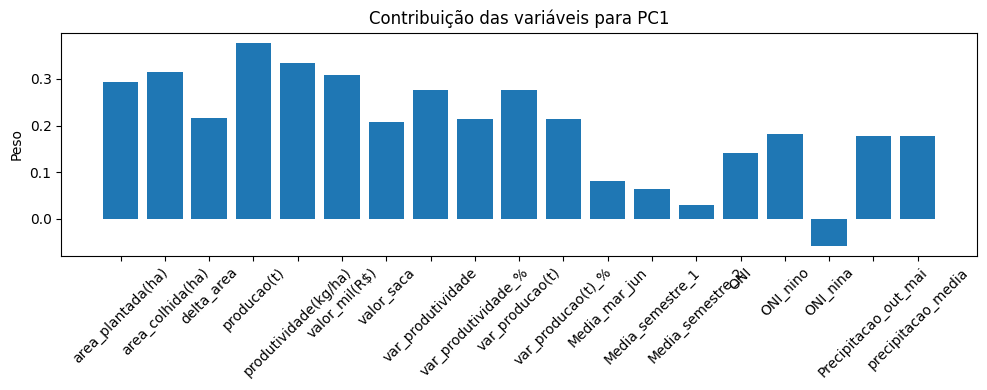

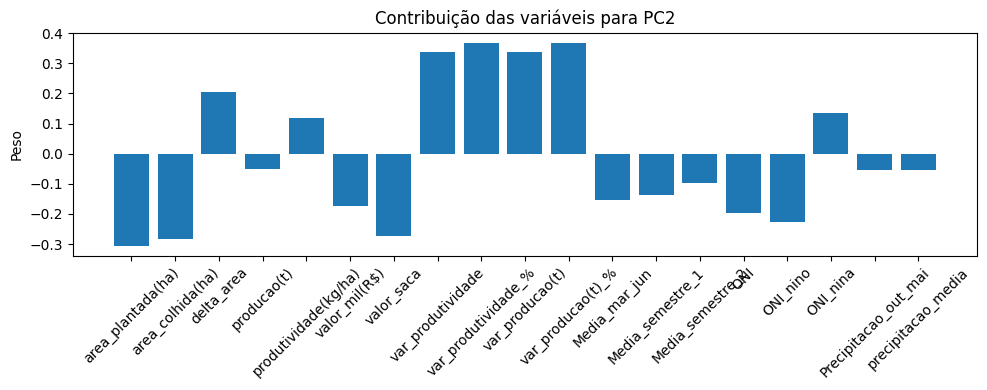

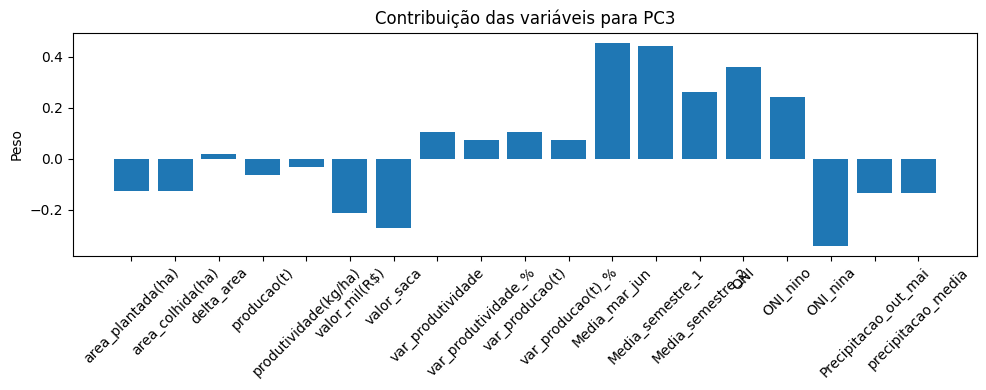

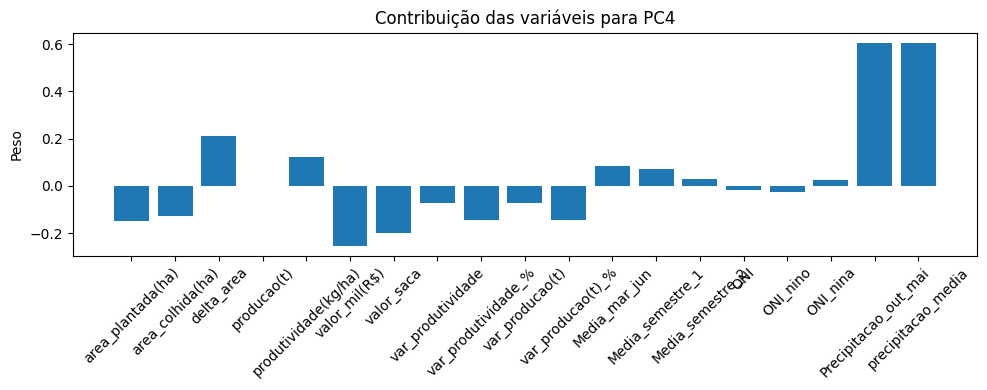

In [234]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.figure(figsize=(10, 4))
    plt.bar(componentes_df.columns, componentes_df.iloc[i])
    plt.title(f'Contribuição das variáveis para PC{i+1}')
    plt.xticks(rotation=45)
    plt.ylabel('Peso')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

### Aplicando a regressão linear para detectar R2 o erro (RMSE) e e construi o modelo preditivo

In [142]:
X = mer[['Evento_mar_jun_num']] #variável independente
y = mer[["producao(t)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=X)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: 0.31
RMSE: 3698524.98


In [164]:
X = mer[['Evento_nov_dez_jan_num']] #variável independente
y = mer[["producao(t)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, stratify = X, random_state = 77)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: -0.35
RMSE: 5176725.62


In [135]:
X = mer[['precipitacao_media']] #variável independente
y = mer[["producao(t)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: -1.42
RMSE: 5024947.45


In [129]:
X = mer[['precipitacao_media']] #variável independente
y = mer[["produtividade(kg/ha)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 72)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: 0.02
RMSE: 830.88


In [136]:
X = mer[['ONI']] #variável independente
y = mer[["producao(t)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: -0.75
RMSE: 4271018.36


In [131]:
X = mer[['ONI_nino']] #variável independente
y = mer[["producao(t)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 72)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: -0.03
RMSE: 4658993.40


In [132]:
X = mer[['ONI_nina']] #variável independente
y = mer[["producao(t)"]] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 72)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: -0.24
RMSE: 5108037.97


In [122]:
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R²: -0.15
RMSE: 4908009.87


In [187]:
coluna_1.ravel()

array([2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2])

In [190]:
y_pred.ravel().round(2)

array([13123154.1 , 13123154.1 , 13123154.1 , 13515168.24, 13123154.1 ,
       13907182.38, 13123154.1 , 13123154.1 , 13123154.1 , 13123154.1 ,
       13123154.1 , 13123154.1 , 13123154.1 , 13907182.38, 13123154.1 ])

In [179]:
coluna_1 = X_test["Evento_nov_dez_jan_num"].values

In [192]:
df_prev = pd.DataFrame({"Evento_nov_dez_jan_num": coluna_1.ravel(),
              "Previsao": y_pred.ravel().round(2)})

In [193]:
df_prev

,Evento_nov_dez_jan_num,Previsao
0,2,13123154.10
1,2,13123154.10
2,2,13123154.10
3,1,13515168.24
4,2,13123154.10
5,0,13907182.38
6,2,13123154.10
7,2,13123154.10
8,2,13123154.10
9,2,13123154.10


In [166]:
y_pred

array([[13123154.0952381 ],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13515168.23809524],
       [13123154.0952381 ],
       [13907182.38095238],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13123154.0952381 ],
       [13907182.38095238],
       [13123154.0952381 ]])

In [153]:
y_test

,producao(t)
13,15700264.0
6,7679939.0
7,8025322.0
1,9579297.0
19,9370339.0
8,10480026.0
18,20420501.0
16,17538725.0
9,11717548.0
15,18744186.0


In [160]:
mer.columns

Index(['Unnamed: 0', 'Ano', 'Unidade da Federação',
       'Produto das lavouras temporárias', 'area_plantada(ha)',
       'area_colhida(ha)', 'delta_area', 'producao(t)', 'produtividade(kg/ha)',
       'valor_mil(R$)', 'valor_saca', 'var_produtividade',
       'var_produtividade_%', 'var_producao(t)', 'var_producao(t)_%',
       'Media_mar_jun', 'Media_semestre_1', 'Media_semestre_2',
       'Evento_mar_jun', 'Evento_nov_dez_jan', 'ONI', 'ONI_nino', 'ONI_nina',
       'Evento_mar_jun_num', 'Evento_nov_dez_jan_num', 'Precipitacao_out_mai',
       'precipitacao_media'],
      dtype='object')

In [159]:
X_test

,Evento_nov_dez_jan_num
13,0
6,2
7,0
1,2
19,2
8,1
18,2
16,2
9,2
15,2


In [157]:
len(y_pred)

15